## Exercise 2: End-to-End Self-Driving via Convolutional Neural Networks

In [30]:
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import cv2

#reading the angles.txt file which contains the image names and its steering angles which is the target values

y_values = pd.read_csv("/kaggle/input/car-steering-angle-prediction/driving_dataset/angles.txt", header=None, sep=" ")
y_values

,0,1
0,0.jpg,0.00
1,1.jpg,0.00
2,2.jpg,0.00
3,3.jpg,0.00
4,4.jpg,0.00
...,...,...
45401,45401.jpg,2.22
45402,45402.jpg,2.22
45403,45403.jpg,2.22
45404,45404.jpg,2.22


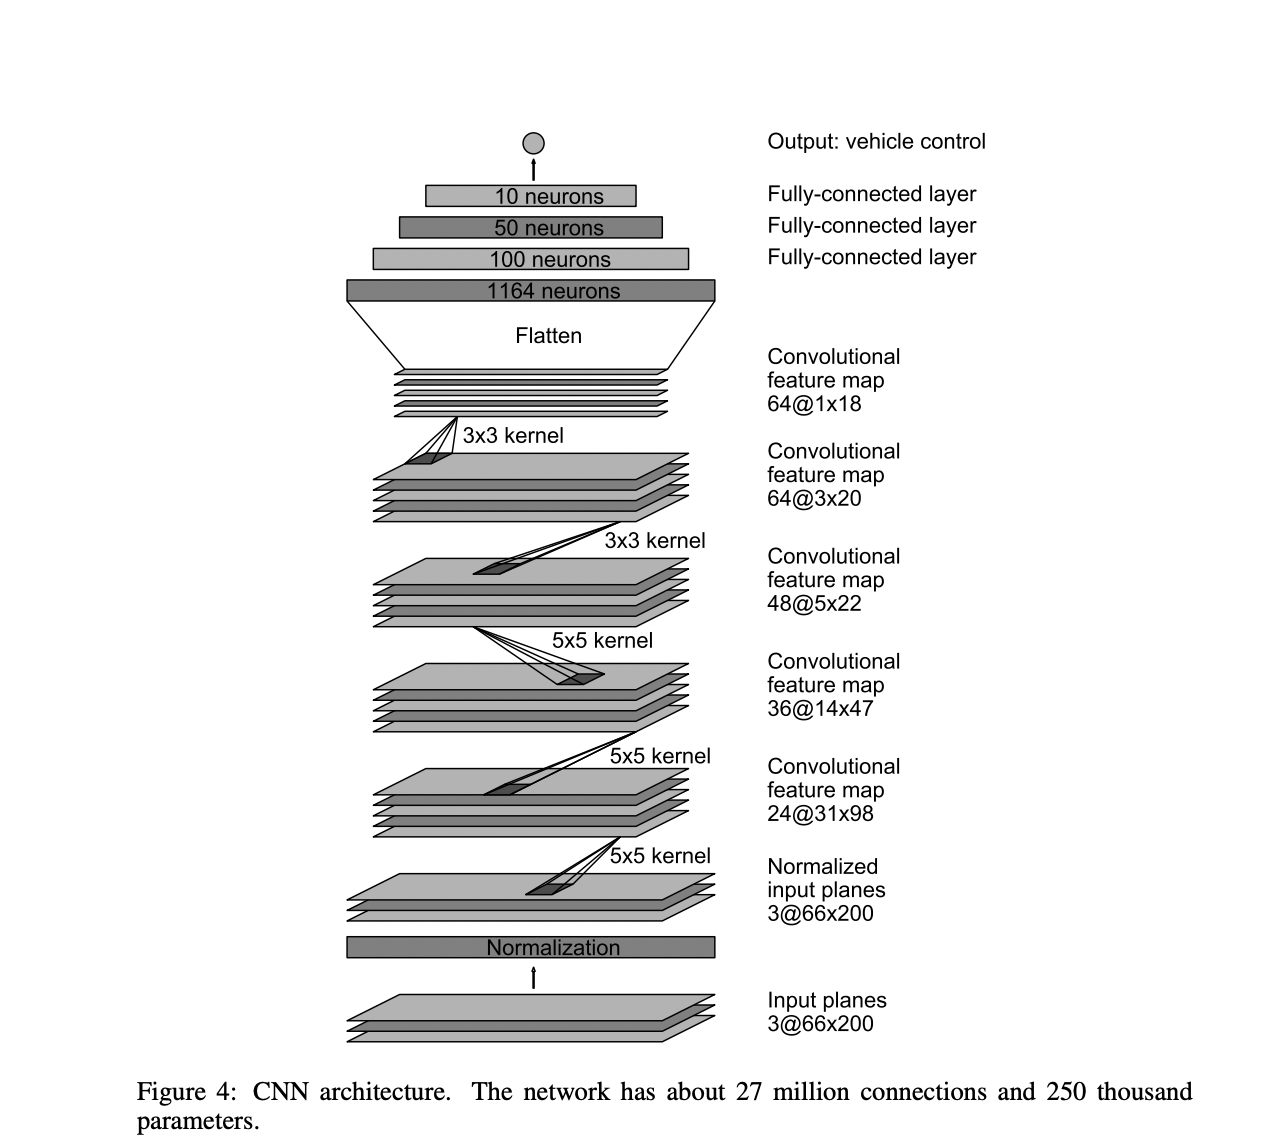

The CNN architecture as given in the paper.

Index 1 corresponds to the target values(steering angle)

In [31]:

#Code to find the size of training ,validation and test sets. Given in sheet (test set size -10K)
total_len = y_values.shape[0]
print(total_len)
len_train = total_len - 20000
len_val = 10000
len_test = 10000
print(len_train)

y_values[1].value_counts()

45406
25406


 0.00      2061
 9.78       485
 8.27       477
 1.51       467
 1.31       406
           ... 
 126.86       1
 124.34       1
 170.92       1
 116.57       1
-50.62        1
Name: 1, Length: 2377, dtype: int64

Class for processing Dataset - given in sheet. The Dataset class is inherited from pytorch and we rewrite the functions accordingly.

In [32]:
class DatasetProcessing(Dataset):  # Inherits from torch.utils.data.Dataset
    def __init__(self,type_data):  
        # default directory where data is loaded
        self.filepath = '/kaggle/input/car-steering-angle-prediction/driving_dataset/'
        self.filenames = []
        #Finding the range for train, validation and test sets according to parameter passed.
        if(type_data == "train"):
            start = 0
            end = len_train
            
        elif(type_data == "val"):
            start = len_train
            end = len_train+len_val
            
        elif(type_data == "test"):
            start = len_train+len_val
            end = len_train+len_val+len_test
            
        for i in range(start,end):    #Finding the filenames in the required range and appending the same
                img = str(i) + ".jpg"
                self.filenames.append(img)
            

    def __len__(self):
        return len(self.filenames)  #Function to find the length of the required data set

    def __getitem__(self, index): # Function to return the image value and the actual target values
        filename = self.filenames[index] #Reading the required images as given in the sheet
        img = cv2.imread(self.filepath + filename)
        #Resizing images to (66,200) as shown in the paper
        resized = cv2.resize(img, (66, 200), interpolation=cv2.INTER_AREA)
        #image converted to numpy array and its corresponding angle (y values)
        return torch.from_numpy(resized.transpose()).float(), y_values[1][index]

Class to implement the Convolutional Network with the parameters, kernels and layers as defined in the paper.
Reference from the code given in the sheet.

In [33]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self._to_linear = 1
    
        # The paramters of the each convulational layers are from the paper given. 
        # There are 5 layers as defined in the paper - diagram in paper
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 24, kernel_size = 5,stride = 2) 
        self.conv2 = nn.Conv2d(24, 36, 5,2)
        self.conv3 = nn.Conv2d(36, 48, 5,2) 
        self.conv4 = nn.Conv2d(48, 64, 3,1) 
        self.conv5 = nn.Conv2d(64, 64, 3,1)
        
        
        self.flatten = nn.Linear(64*1*18, 1164) #Flattens layers as provided in paper
        
        # 3 fully connected layers with linear transformations
        self.lin1 = nn.Linear(in_features = 1164, out_features = 100) #params given in paper
        self.lin2 = nn.Linear(100, 50)
        self.lin3 = nn.Linear(50, 10)
        self.linout = nn.Linear(10, 1) #Output control

    def forward(self, x):
        #Calling each of the layers of the model and outputing the cnn model
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        
        x = x.view(-1, 1152) #re-shaping x with 1152 columns and appropriate number of rows, used before flattening
        
        x = self.flatten(x) 
        
        x = self.lin1(x)
        x = self.lin2(x)
        x = self.lin3(x)
        x = self.linout(x)
        return x

net = ConvNet()  #Calling the ConvolutionalModel
optimizer = torch.optim.SGD(net.parameters(), lr=1e-3)  #SGD optimizer with CNN model and given learning rate as in sheet
criterion = nn.MSELoss() #mean square error loss taken as the criteria for checking accuracy



Code to create the train dataset ( x and y values ) given in the sheet and to find the y values using the cnn model created. 

Loss is found for each batch. Code from the sheet.

In [34]:
train_data = DatasetProcessing("train") #passing parameter to get train dataset
train_loader = torch.utils.data.DataLoader(train_data, batch_size=500, shuffle=True) #Batch size taken as 500 to reduce the iterations as it is a huge dataset


for i, sample_batched_train in enumerate(train_loader):  # for each batch
    optimizer.zero_grad()
    y_hat_train = net(sample_batched_train[0]) #finding the y values as the ouput of the cnn
    train_loss = torch.sqrt(criterion(y_hat_train.squeeze(), sample_batched_train[1].type(torch.float32)))  
    # Using torch.sqrt to get RMSE from mse
    print("The rmse value of train data set for batch",i,"is:",train_loss.item())
 
    train_loss.backward() #backpropagation of error
    optimizer.step() #optimising the parameters using the loss

The rmse value of train data set for batch 0 is: 35.17258834838867
The rmse value of train data set for batch 1 is: 32.461612701416016
The rmse value of train data set for batch 2 is: 23.494470596313477
The rmse value of train data set for batch 3 is: 37.40959167480469
The rmse value of train data set for batch 4 is: 34.12856674194336
The rmse value of train data set for batch 5 is: 24.360897064208984
The rmse value of train data set for batch 6 is: 30.998233795166016
The rmse value of train data set for batch 7 is: 33.1523323059082
The rmse value of train data set for batch 8 is: 29.229616165161133
The rmse value of train data set for batch 9 is: 26.492156982421875
The rmse value of train data set for batch 10 is: 30.590810775756836
The rmse value of train data set for batch 11 is: 40.505428314208984
The rmse value of train data set for batch 12 is: 39.92749786376953
The rmse value of train data set for batch 13 is: 28.391836166381836
The rmse value of train data set for batch 14 is: 

CNN for the validation dataset. The rmse is found for each batch. Code similar to that for train data set

In [35]:
validation_data = DatasetProcessing("val") #To identify the dataset
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=200, shuffle=True) #batch size chosen randomly


for i, sample_batched_val in enumerate(validation_loader):
    y_hat_val = net(sample_batched_val[0])
    val_loss = torch.sqrt(criterion(y_hat_val.squeeze(), sample_batched_val[1].type(torch.float32)))
    print("The rmse value of validation data set for batch",i,"is:",val_loss.item())
    val_loss.backward()
    optimizer.step()
    

The rmse value of validation data set for batch 0 is: 45.116634368896484
The rmse value of validation data set for batch 1 is: 51.90215301513672
The rmse value of validation data set for batch 2 is: 40.686580657958984
The rmse value of validation data set for batch 3 is: 38.10529708862305
The rmse value of validation data set for batch 4 is: 29.32744789123535
The rmse value of validation data set for batch 5 is: 31.066686630249023
The rmse value of validation data set for batch 6 is: 41.47411346435547
The rmse value of validation data set for batch 7 is: 50.002315521240234
The rmse value of validation data set for batch 8 is: 40.41080856323242
The rmse value of validation data set for batch 9 is: 35.723663330078125
The rmse value of validation data set for batch 10 is: 46.517940521240234
The rmse value of validation data set for batch 11 is: 46.920570373535156
The rmse value of validation data set for batch 12 is: 38.06309509277344
The rmse value of validation data set for batch 13 is:

CNN is implemented for test data set. Loss is found for each batch and one RMSE is found for the test set of images. 
Code is similar to that done above

In [36]:

test_data = DatasetProcessing("test") # for test dataset
test_loader = torch.utils.data.DataLoader(test_data, batch_size=200, shuffle=True)


test_loss_list = []    
for i, sample_batched_test in enumerate(test_loader):
    y_hat_test = net(sample_batched_test[0])
    test_loss = torch.sqrt(criterion(y_hat_test.squeeze(), sample_batched_test[1].type(torch.float32)))
    test_loss_list.append(test_loss.item())
    print("The rmse value of test data set for batch",i,"is:",test_loss.item())

The rmse value of test data set for batch 0 is: 51.00648880004883
The rmse value of test data set for batch 1 is: 41.301177978515625
The rmse value of test data set for batch 2 is: 38.09858703613281
The rmse value of test data set for batch 3 is: 52.52141189575195
The rmse value of test data set for batch 4 is: 47.371742248535156
The rmse value of test data set for batch 5 is: 52.32469940185547
The rmse value of test data set for batch 6 is: 54.38444900512695
The rmse value of test data set for batch 7 is: 45.32197952270508
The rmse value of test data set for batch 8 is: 37.78889846801758
The rmse value of test data set for batch 9 is: 47.06938934326172
The rmse value of test data set for batch 10 is: 44.847965240478516
The rmse value of test data set for batch 11 is: 51.753116607666016
The rmse value of test data set for batch 12 is: 41.14284896850586
The rmse value of test data set for batch 13 is: 35.42976379394531
The rmse value of test data set for batch 14 is: 49.89753723144531
T

In [37]:
print("Mean rmse test loss for test set of images-", sum(test_loss_list)/len(test_loss_list))

Mean rmse test loss for test set of images- 46.727148933410646


References:

https://arxiv.org/pdf/1604.07316.pdf
https://cs231n.github.io/convolutional-networks/
https://pytorch.org/tutorials/beginner/pytorch_with_examples.html
https://machinelearningknowledge.ai/pytorch-conv2d-explained-with-examples/
https://towardsdatascience.com/convolutional-neural-network-to-steer-a-vehicle-inside-a-game-2aab41a5ef60
https://stackoverflow.com/questions/42479902/how-does-the-view-method-work-in-pytorch
https://pytorch.org/docs/stable/generated/torch.rand.html
https://towardsdatascience.com/building-efficient-custom-datasets-in-pytorch-2563b946fd9f
https://stackoverflow.com/questions/61990363/rmse-loss-for-multi-output-regression-problem-in-pytorch

## Hyperparameter Tuning, Regularization with Image Transformations 

To Tune the associated hyperparameters such as batch_size, number_of_layers, kernel_sizes, learning_rate, l1_regularization, l2_regularization coefficients etc. Either implement Random Search or Hyperband.


In [42]:
from sklearn.model_selection import RandomizedSearchCV

params = {'batch_size':np.linspace(100, 500, num=5),'lr':np.linspace(0.00001, 0.1, num=5)}

x = RandomizedSearchCV(net,params)
x


RandomizedSearchCV(estimator=ConvNet(
  (conv1): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
  (conv3): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
  (conv4): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Linear(in_features=1152, out_features=1164, bi...
  (lin1): Linear(in_features=1164, out_features=100, bias=True)
  (lin2): Linear(in_features=100, out_features=50, bias=True)
  (lin3): Linear(in_features=50, out_features=10, bias=True)
  (linout): Linear(in_features=10, out_features=1, bias=True)
),
                   param_distributions={'batch_size': array([100., 200., 300., 400., 500.]),
                                        'lr': array([1.00000e-05, 2.50075e-02, 5.00050e-02, 7.50025e-02, 1.00000e-01])})